# Leveraged ETFs: The Compounding Problem

:::::{grid} 2
:::{card} 
**[Billions Flowed Into New Leveraged ETFs Last Year. Now They’re in Free Fall.](https://www.wsj.com/finance/investing/billions-flowed-into-new-leveraged-etfs-last-year-now-theyre-in-free-fall-0c413245)**
WSJ - March 20, 2025
Wall Street’s newest roller-coaster trade, the leveraged single-stock ETF, is plunging.
:::

:::{card} 
**[The Hidden Cost of Playing the Stock Market’s Slot Machine](https://www.wsj.com/finance/investing/the-hidden-cost-of-playing-the-stock-markets-slot-machine-0512d452)**
WSJ - Oct 3, 2025
Superpowered ETFs make money fast, but cost more than you know
:::


:::{card} 
**[How Booming Leveraged Funds Can Incinerate Your Money](https://www.wsj.com/finance/investing/how-booming-leveraged-funds-can-incinerate-your-money-68241a9c)**  
WSJ - Dec 11, 2024
Variants soon might include long-short funds
:::


:::{card} 
**[How Index‑Fund Investing Turned Into an Extreme Sport](https://www.wsj.com/finance/investing/how-index-fund-investing-turned-into-an-extreme-sport-d555b5ed)**  
WSJ - July 11, 2025  
Exchange-traded funds are becoming far more concentrated, amplifying risks.
:::

:::::


In [ ]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,4)
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 12

from cmds.portfolio import performanceMetrics, tailMetrics, maximumDrawdown, get_ols_metrics

# The Math Behind the Problem

## Traditional Leverage vs. Leveraged ETFs

**Traditional leverage:** Borrow money once, hold the position
$$r_{0,T}^{\text{Traditional}} = w \cdot [(1+r_1)(1+r_2)\cdots(1+r_T) - 1]$$

**Leveraged ETF:** Rebalance the leverage daily  
$$r_{0,T}^{\text{LETF}} = (1+w \cdot r_1)(1+w \cdot r_2)\cdots(1+w \cdot r_T) - 1$$

### The Key Insight

<div style="background-color: #e8f4fd; padding: 15px; border-left: 4px solid #2196F3; margin: 10px 0;">
<strong>These are NOT the same!</strong><br>
Daily rebalancing creates compounding effects that can work against you, especially during volatile periods.
</div>

## A Simple Example

Let's see this in action with 3x leverage over 2 days:

**Traditional 3x leverage:**  
$$3r_1 + 3r_2 + 3r_1r_2$$

**3x Leveraged ETF:**  
$$3r_1 + 3r_2 + 9r_1r_2$$

**The difference:** $6r_1r_2$ 

When returns have opposite signs (common in volatile markets), this difference hurts the LETF.

### Illustration

Suppose the following...

In [ ]:
leverage = 3
r1 = .1
r2 = -.05
cumret = (1+r1)*(1+r2) - 1
leveraged_cumret = leverage * cumret
letf_cumret = (1+leverage*r1)*(1+leverage*r2) - 1
diff = -(leverage*(leverage-1)) * r1*r2

df = pd.DataFrame([leverage, r1, r2, cumret, leveraged_cumret, letf_cumret, diff], index=['Leverage', 'r1', 'r2', 'Cumulative Return', 'Levered Cumulative Return', 'LETF Cumulative Return', 'Difference'],columns=['illustration'])
display(df.style.format('{:.1%}'))

**What just happened?**

The LETF lost 3% due to daily rebalancing! This is the **volatility drag** effect.


### The Bottom Line

<div style="background-color: #e8f4fd; padding: 15px; border-left: 4px solid #2196F3; margin: 10px 0;">
<h3>Leveraged ETFs are NOT long-term investments</h3>
<ul>
<li><strong>Daily rebalancing</strong> creates compounding drag</li>
<li><strong>Volatility amplifies</strong> the decay effect</li>
<li><strong>Time works against you</strong> - the longer you hold, the worse it gets</li>
<li><strong>Use case:</strong> Short-term tactical trades, not buy-and-hold</li>
</ul>
</div>

**The math doesn't lie:** $(1+3r_1)(1+3r_2) \neq 1 + 3(r_1 + r_2)$ when $r_1 \cdot r_2 \neq 0$


# Levered SPX

Let's examine actual leveraged ETFs to see this effect in practice.

**ETFs we're analyzing:**
- **UPRO**: 3x Long S&P 500  
- **SPXU**: 3x Inverse S&P 500
- **SPY**: The underlying S&P 500 ETF

In [ ]:
FREQ = 252

filepath_data = '../data/letf_data.xlsx'
info = pd.read_excel(filepath_data,sheet_name='descriptions')
info.set_index('ticker',inplace=True)
info.rename(columns={'trailingAnnualDividendYield':'dvd yield'},inplace=True)


rets = pd.read_excel(filepath_data,sheet_name='total returns')
rets.set_index('date',inplace=True)
rets.dropna(inplace=True)

In [ ]:
info.loc[['SPY','UPRO','SPXU'],:].style.format({'volume':'{:.0e}','totalAssets':'{:.0e}','dvd yield':'{:.0%}'},na_rep='')

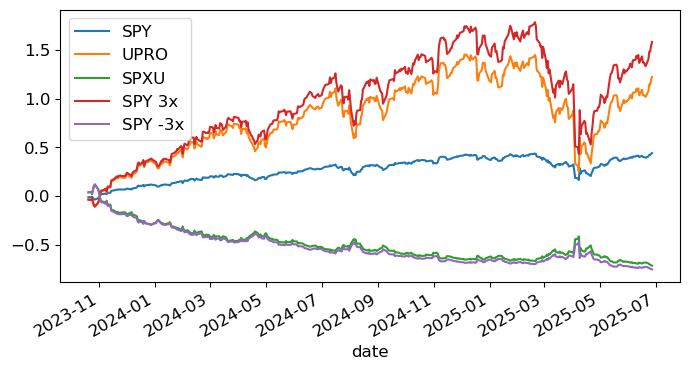

In [ ]:
spy = rets[['SPY','UPRO','SPXU']].copy()
spy['SPY 3x'] = 3 * spy['SPY']
spy['SPY -3x'] = -3 * spy['SPY']

spy_cumrets = ((spy+1).cumprod()-1)
spy_cumrets.plot(logy=False)
plt.show()

**Key insight:** Look at how the leveraged ETFs track against theoretical 3x performance.


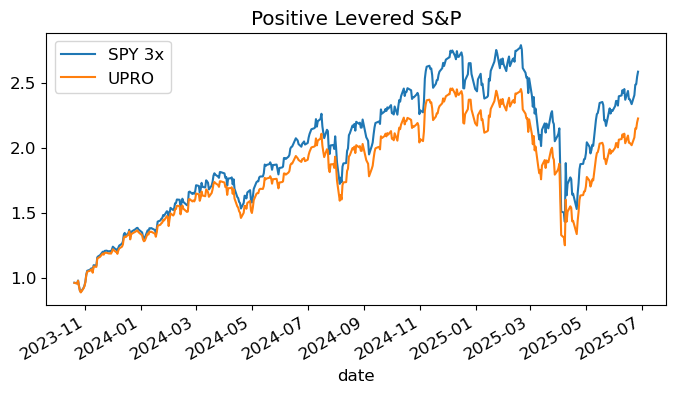

In [ ]:
cumrets = (1+spy).cumprod()
cumrets[['SPY 3x','UPRO']].plot(title='Positive Levered S&P')
plt.show()

**What we're seeing:** The leveraged ETFs consistently underperform their theoretical targets during volatile periods.


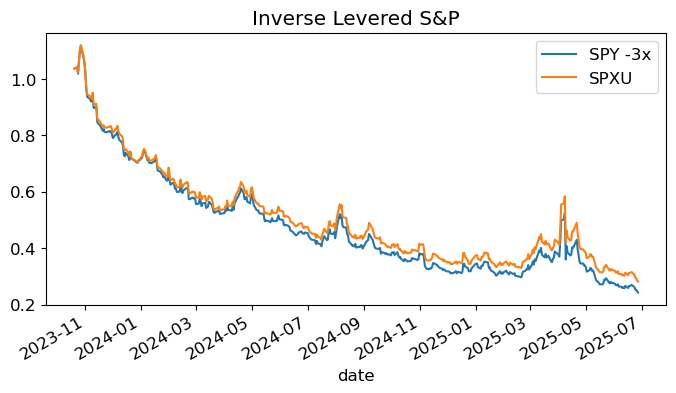

In [ ]:
cumrets[['SPY -3x','SPXU']].plot(title='Inverse Levered S&P')
plt.show()

**The decay effect:** Over time, leveraged ETFs lose value relative to simple leveraged positions due to daily rebalancing.


## Performance Breakdown


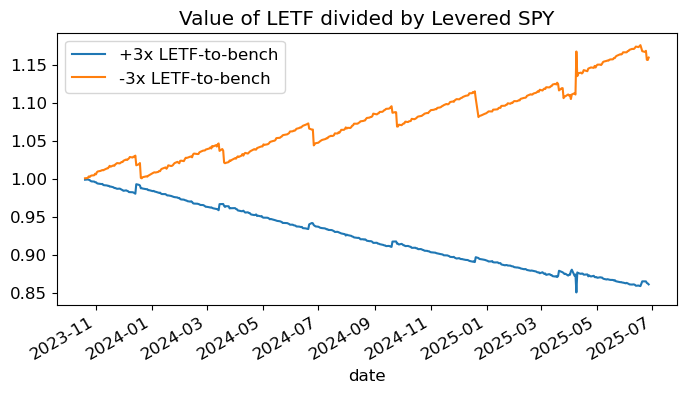

In [ ]:
cumrets_decay = pd.DataFrame((cumrets['UPRO'] / cumrets['SPY 3x']), columns=['+3x LETF-to-bench'])
cumrets_decay['-3x LETF-to-bench'] = (cumrets['SPXU'] / cumrets['SPY -3x'])

cumrets_decay.plot(title='Value of LETF divided by Levered SPY');

## Risk-Return Analysis


In [ ]:
performanceMetrics(spy,annualization=FREQ).style.format("{:.1%}")

In [ ]:
maximumDrawdown(spy).style.format({'Max Drawdown': "{:.1%}","Peak": "{:%Y-%m-%d}",'Bottom': "{:%Y-%m-%d}",'Recover':"{:%Y-%m-%d}"},na_rep='')

In [ ]:
get_ols_metrics(spy['SPY'],spy,annualization=12).drop(columns=['Treynor Ratio','Info Ratio']).style.format('{:.1%}')

# LETF for Single-Name Stock

In [ ]:
rets['NVDA 2x'] = 2 * rets['NVDA']
rets['NVDA -2x'] = -2 * rets['NVDA']

rets['SPY 2x'] = 2 * rets['SPY']
rets['SPY -2x'] = -2 * rets['SPY']

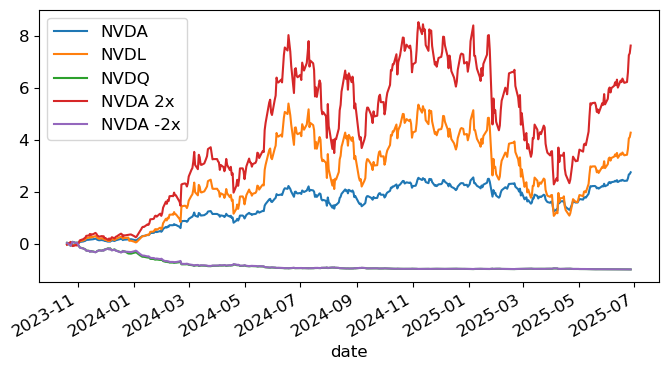

In [ ]:
nvda = rets[['NVDA','NVDL','NVDQ','NVDA 2x','NVDA -2x']]
nvda_cumrets = ((nvda+1).cumprod()-1)
nvda_cumrets.plot(logy=False)
plt.show()

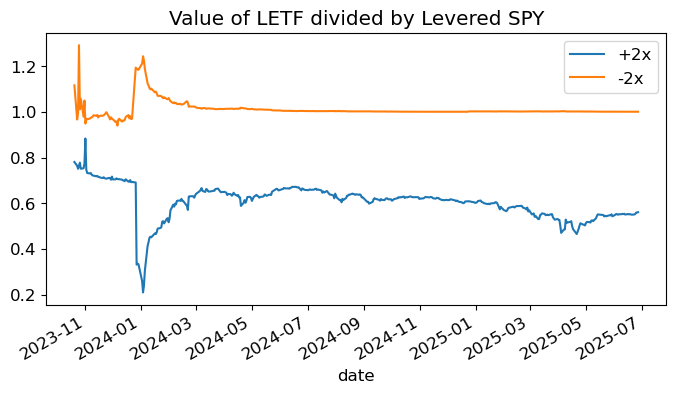

In [ ]:
nvda_cumrets_decay = pd.DataFrame((nvda_cumrets['NVDL'] / nvda_cumrets['NVDA 2x']), columns=['+2x'])
nvda_cumrets_decay['-2x'] = (nvda_cumrets['NVDQ'] / nvda_cumrets['NVDA -2x'])

nvda_cumrets_decay.plot(title='Value of LETF divided by Levered SPY');

In [ ]:
get_ols_metrics(nvda['NVDA'],nvda,annualization=FREQ).drop(columns=['Treynor Ratio','Info Ratio']).style.format('{:.1%}')

:::::{grid} 2
:::{card} 
**[SEC Statement on Single-Stock Levered and/or Inverse ETFs](https://www.investor.gov/statement-single-stock)**
SEC - July 8, 2022

:::



:::{card} 
**[SEC Updated Investor Bulletin: Leveraged and Inverse ETFs](https://www.investor.gov/introduction-investing/general-resources/news-alerts/alerts-bulletins/investor-alerts/sec)**  
SEC - Aug 29, 2023

:::


:::::
